In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def generate_datasets(num_investors=100000):
    np.random.seed(42)
    market_growth = np.random.uniform(-15, 15, num_investors)
    interest = np.random.uniform(0, 8, num_investors) 
    data = np.column_stack((market_growth, interest))
    return data

In [ ]:
def discretize_context(context, num_cells_per_dimension=10):
    market_growth = context[0]
    interest = context[1]
    
    market_growth_range = 30  # Rango de market_growth: 15 - -15 = 30
    interest_range = 8  # Rango de interest: 8 - 0 = 8

    market_growth_cell_size = market_growth_range / num_cells_per_dimension
    interest_cell_size = interest_range / num_cells_per_dimension
    
    row = int((market_growth + 15) // market_growth_cell_size)  
    col = int(interest // interest_cell_size)
    cell_index = row * num_cells_per_dimension + col
    return cell_index


In [ ]:
def min_max_scaling(array, min_val=0, max_val=100):
    min_array = np.min(array)
    max_array = np.max(array)
    return (array - min_array) * (max_val - min_val) / (max_array - min_array) + min_val

In [ ]:
arm_compositions = [
    {"acciones": 0, "bonos": 100},
    {"acciones": 25, "bonos": 75},
    {"acciones": 50, "bonos": 50},
    {"acciones": 75, "bonos": 25},
    {"acciones": 100, "bonos": 0},
]

In [ ]:
def generate_arm_probabilities(context, arm_compositions):
    num_arms = len(arm_compositions)
    arm_probabilities = []
    market_growth = context[0]
    interest = context[1]
    a = 14.2
    b = 0
    c = 3
    d = 50
    var_acciones = 4
    var_bonos = 2
    correlacion = 0.7

    normalized_portfolio_returns = []

    for arm in arm_compositions:
        actions_ratio = arm['acciones'] / 100
        bonds_ratio = arm['bonos'] / 100

        E_acciones = a * market_growth  + b
        E_bonos = c * interest + d
        
        E_cartera = actions_ratio * E_acciones + bonds_ratio * E_bonos

        cov_acciones_bonos = correlacion * np.sqrt(var_acciones) * np.sqrt(var_bonos) 

        var_cartera = (actions_ratio**2) * var_acciones + (bonds_ratio**2) * var_bonos + 2 * actions_ratio * bonds_ratio * cov_acciones_bonos


        cartera_dist = np.random.normal(E_cartera, np.sqrt(var_cartera), 10000)

        cartera_dist = np.clip(cartera_dist, 0, 100)  # Acotar los valores entre 0 y 100
        cartera_dist /= 100
        normalized_cartera_dist = cartera_dist
        normalized_portfolio_returns.append(normalized_cartera_dist)

    arm_probabilities = np.array([np.random.choice(dist) for dist in normalized_portfolio_returns])

    return arm_probabilities

In [ ]:
def reward_function(context, arm, arm_compositions):
    probs = generate_arm_probabilities(context,arm_compositions)
    return probs[arm]

In [ ]:
def check_lipschitz_condition(context_arm_rewards, arm_compositions, data, lipschitz_constant):
    num_contexts, num_arms = context_arm_rewards.shape
    for i in range(num_contexts):
        for j in range(i + 1, num_contexts):
            context_i = data[i]
            context_j = data[j]
            context_distance = np.linalg.norm(context_i - context_j)

            for a in range(num_arms):
                reward_diff = abs(context_arm_rewards[i, a] - context_arm_rewards[j, a])
                if reward_diff > lipschitz_constant * context_distance:
                    return False
    return True

In [ ]:
class UCB1:
    """
    Implementación del algoritmo UCB1.
    """
    def __init__(self, num_arms):
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        n_total = sum(self.counts)
        if n_total == 0:
            return np.random.randint(len(self.counts))

        term = 1e-5
        explore_rate = 2 * np.log(n_total) / (self.counts + term)
        ucb_values = self.values + np.sqrt(explore_rate)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = ((self.counts[arm] - 1) * self.values[arm] + reward) / self.counts[arm]


In [ ]:
def plot_rewards_and_lossesLearn(total_reward, total_loss, T):
    plt.figure(figsize=(12, 6))
    
    avg_reward = np.cumsum(total_reward) / np.arange(1, T + 1)
    avg_loss = np.cumsum(total_loss) / np.arange(1, T + 1)

    plt.subplot(1, 2, 1)
    plt.plot(range(T), avg_reward, label='Bandidos Contextuales tipo Lipschitz')
    plt.xlabel('Número de rondas')
    plt.ylabel('Recompensas')
    plt.title('Recompensas medias')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(T), avg_loss, label='Bandidos Contextuales tipo Lipschitz')
    plt.xlabel('Número de rondas')
    plt.ylabel('Remordimiento')
    plt.title('Remordimiento medio')
    plt.legend()
    
    plt.show()

def plot_rewards_and_losses(total_reward, total_loss, T):
    plt.figure(figsize=(12, 6))
    
  

    plt.subplot(1, 2, 1)
    plt.plot(range(T), total_reward, label='Bandidos Contextuales tipo Lipschitz')
    plt.xlabel('Número de rondas')
    plt.ylabel('Recompensas')
    plt.title('Recompensas obtenidas')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(T), total_loss, label='Bandidos Contextuales tipo Lipschitz')
    plt.xlabel('Número de rondas')
    plt.ylabel('Remordimiento')
    plt.title('Remordimiento')
    plt.legend()
    
    plt.show()

In [ ]:
def plot_mean_rewards(tmp, num_cells_per_dimension):
    reward_matrix = np.zeros((num_cells_per_dimension, num_cells_per_dimension))

    for i in range(num_cells_per_dimension * num_cells_per_dimension):
        row = i // num_cells_per_dimension
        col = i % num_cells_per_dimension
        reward_matrix[row, col] = tmp[i]

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(reward_matrix, cmap='viridis', origin='lower')

    ax.set_xticks(range(num_cells_per_dimension))
    ax.set_yticks(range(num_cells_per_dimension))
    ax.set_xlabel('Interés discretizado')
    ax.set_ylabel('Crecimiento del mercado discretizado')

    fig.colorbar(im)
    fig.suptitle('Recompensas medias por contexto discretizado')
    plt.show()

In [ ]:
def most_played_arms(num_contexts, instances):
    arm_counts = np.zeros((num_contexts, len(instances[0].counts)))

    for i, instance in enumerate(instances):
        arm_counts[i] = instance.counts

    most_played = np.argmax(arm_counts, axis=1)
    return most_played
   
def plot_most_played_arms_grid(most_played_arms, num_contexts, num_arms, num_cells_per_dimension):
    grid = np.zeros((num_cells_per_dimension, num_cells_per_dimension))

    for i in range(num_contexts):
        row = i // num_cells_per_dimension
        col = i % num_cells_per_dimension
        grid[row, col] = most_played_arms[i]

    plt.figure(figsize=(8, 8))
    plt.imshow(grid, cmap=plt.cm.get_cmap('viridis', num_arms), origin='lower', vmin=0, vmax=num_arms - 1)
    plt.colorbar(ticks=range(num_arms), format='Arm %d')
    plt.title('Brazo más jugado por contexto discretizado')
    plt.xlabel('Contexto discretizado X (Interés)')
    plt.ylabel('Contexto discretizado Y (Crecimiento del mercado)')
    plt.xticks(range(num_cells_per_dimension))
    plt.yticks(range(num_cells_per_dimension))
    plt.show()


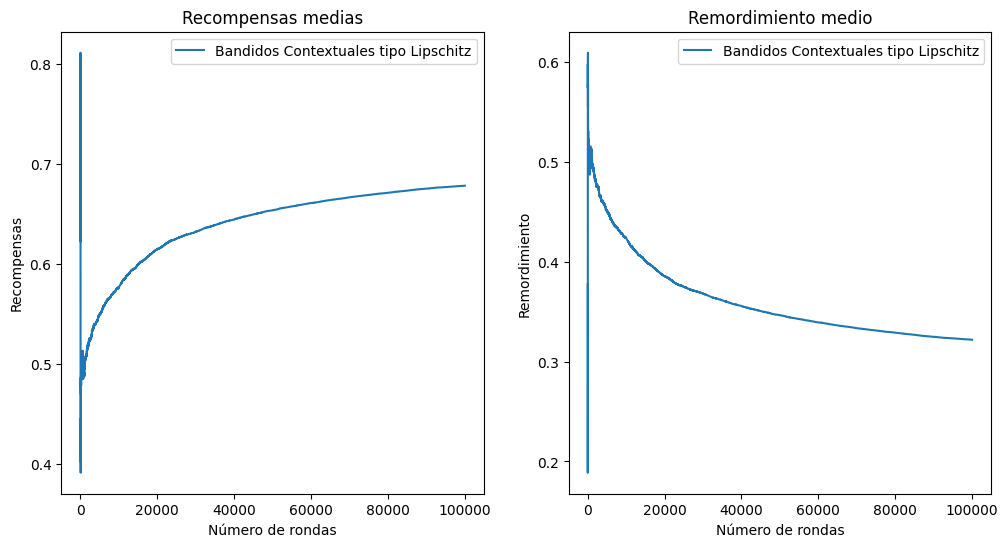

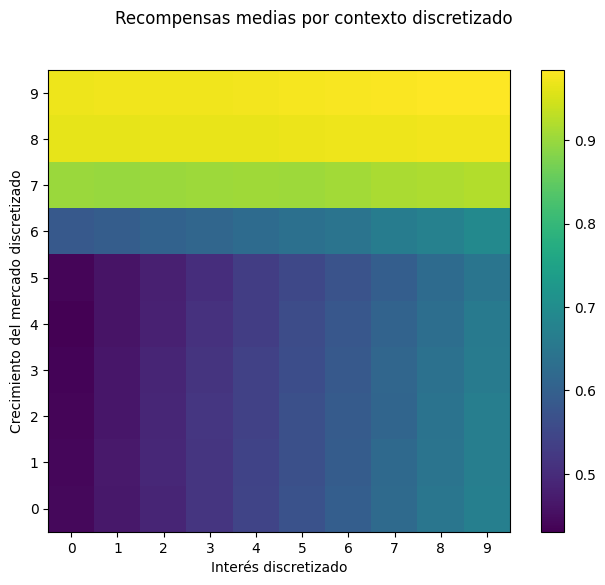

In [ ]:
num_contextos_discretz = 100
data = generate_datasets()
T = len(data)
instanceUCB = UCB1(len(arm_compositions))

instances = [UCB1(len(arm_compositions)) for _ in range(num_contextos_discretz)]  
total_reward = np.zeros(T)
total_loss = np.zeros(T)
tmp = np.zeros(num_contextos_discretz) # variable auxiliar
count = np.zeros(num_contextos_discretz)
context_arm_rewards = np.zeros((num_contextos_discretz, len(arm_compositions)))

for i in range(T):
    context = data[i]
    discretized_context = discretize_context(context)
    count[discretized_context] += 1
    alg = instances[discretized_context]
    arm = alg.select_arm()
    contextual_reward = reward_function(context, arm, arm_compositions)
    alg.update(arm, contextual_reward)
    total_reward[i] = contextual_reward
    total_loss[i] = (1 - contextual_reward)
    tmp[discretized_context] += contextual_reward

    current_mean = context_arm_rewards[discretized_context, arm]
    updated_mean = ((count[discretized_context] - 1) * current_mean + contextual_reward) / count[discretized_context]
    context_arm_rewards[discretized_context, arm] = updated_mean

plot_rewards_and_lossesLearn(total_reward, total_loss, T)
most_played = most_played_arms(num_contextos_discretz, instances)
tmp = tmp /count
lipschitz_constant = 10
plot_mean_rewards(tmp, 10)

